# Registration of Tungsten fibres on XCT images

This demo aims to demonstrate the use of [gVirtualXRay](http://gvirtualxray.sourceforge.net/) and mathematical optimisation to register polygon meshes onto X-ray microtomography (micro-CT) scans of a tungsten fiber.

![The fibre.](scanned_object.png)

For this purpose, we are using SimpleGVXR's Python wrapper and Python packages commonly used in tomography reconstruction ([Tomopy](https://tomopy.readthedocs.io/en/latest/)), image processing ([scikit-image](https://scikit-image.org/) and [SimpleITK](https://simpleitk.org/)), computer vision ([OpenCV](https://www.opencv.org/)), and non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma)).

## Import packages

We need to import a few libraries (called packages in Python). We use:

- `copy`: duplicating images using deepcopies;
- `math`: the `floor` function;
- `os`: creating a new directory
- `numpy`: who doesn't use numpy~
- `skimage`: computing the Radon transform of an image, and perform a CT reconstruction using FBP and SART;
- `tomopy`: another package for CT reconstruction;
- `SimpleITK`: image processing and saving volume data;
- OpenCV (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter)
- `matplotlib`: plotting data
- `cma`: non-linear numerical optimization
- `gvxrPython3`: simulation of X-ray images using the Beer-Lambert law on GPU

In [2]:
import copy, math, os

import numpy as np

from skimage.transform import radon, iradon, iradon_sart

import tomopy

import SimpleITK as sitk

import cv2

import cma

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#from FlyAlgorithm import *
#from lsf import *

import gvxrPython3 as gvxr

## Create a new directory to save the outputs

In [3]:
if not os.path.exists("outputs"):
    os.makedirs("outputs");

## Global variables

We need some global variables.

- `g_reference_CT`: The reference XCT slice;
- `g_reference_sinogram`: The Radon transform of the reference XCT slice;
- `g_pixel_spacing_in_micrometre` and `g_pixel_spacing_in_mm`: The physical distance between the centre of two successive pixel;
- `g_number_of_projections`: The total number of angles in the sinogram;
- `g_angular_span_in_degrees`: The angular span covered by the sinogram;
- `g_angular_step`: the angular step; and
- `g_theta`: The rotation angles in degrees (vertical axis of the sinogram).

In [2]:
# Target of the registration
g_reference_CT       = np.zeros(1);
g_reference_sinogram = np.zeros(1);

In [3]:
g_pixel_spacing_in_micrometre = 1.9;
g_pixel_spacing_in_mm = g_pixel_spacing_in_micrometre * 1e-3;
g_number_of_projections = 360;
g_angular_span_in_degrees = 180.0;
g_angular_step = g_angular_span_in_degrees / g_number_of_projections;
g_theta = np.linspace(0., g_angular_span_in_degrees, g_number_of_projections, endpoint=False);

## Load the image data

Load and display the reference XCT slice, i.e. the target of the registration

In [4]:
reference_CT = np.loadtxt("W_ML_20keV.tomo-original.txt");

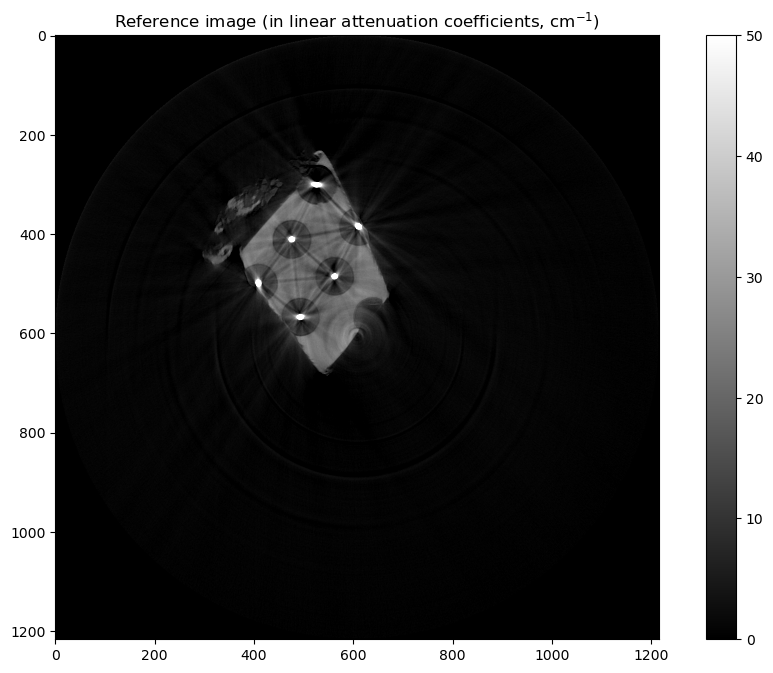

In [5]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=50, vmin=0)
imgplot = plt.imshow(reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");

Compute the Radon transform of the reference XCT slice, save it, and it

In [6]:
reference_sinogram = radon(reference_CT, theta=g_theta, circle=True).T;

#np.savetxt("outputs/sinogram_ref.txt", reference_sinogram);
volume = sitk.GetImageFromArray(reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "outputs/sinogram_ref.mha", useCompression=True);


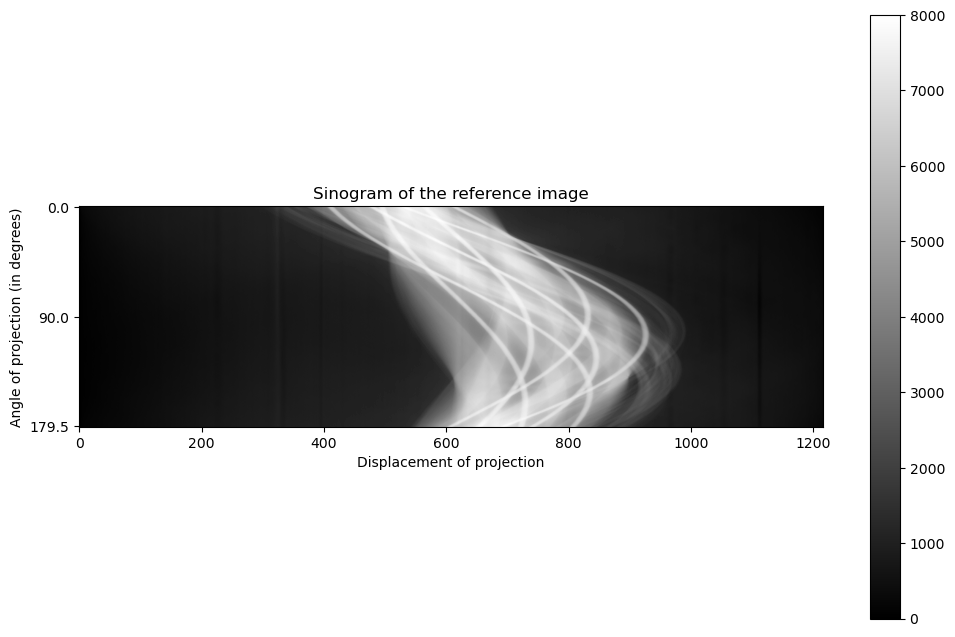

In [7]:
labels=[g_theta[0], g_theta[reference_sinogram.shape[0] // 2], g_theta[-1]];
tics=[0, reference_sinogram.shape[0] // 2, reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);

## Find circles

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT8. We blur it using a bilateral filter (an edge-preserving smoothing filter).

### Convert the image to UINT8

In [8]:
temp_reference = copy.deepcopy(reference_CT);
temp_reference -= np.min(temp_reference);
temp_reference /= np.max(temp_reference);
temp_reference *= 255;
temp_reference = temp_reference.astype(np.uint8);

blur = cv2.bilateralFilter(temp_reference, 9, 75, 75);
np.savetxt("outputs/blur.txt", blur);

### Plot the reference image after the application of the bilateral filter

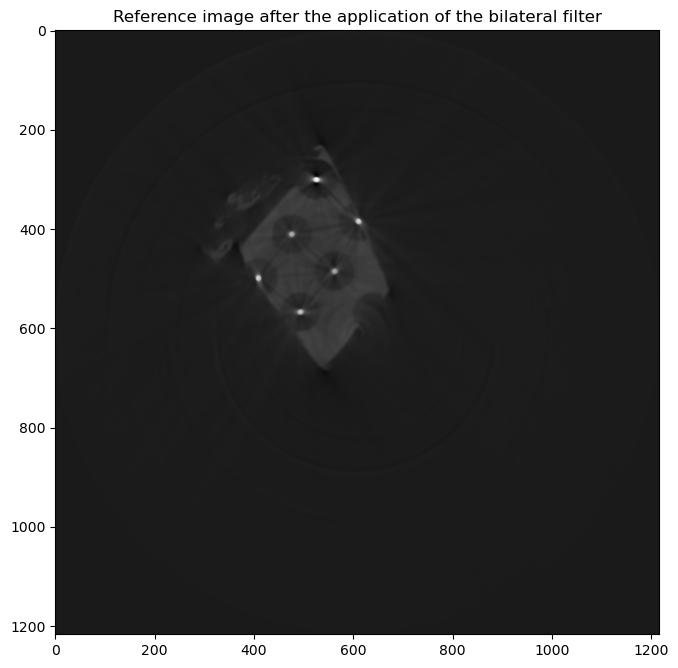

In [9]:
fig=plt.figure();
imgplot = plt.imshow(blur, cmap="gray");
plt.title("Reference image after the application of the bilateral filter");

### Apply the Hough transform

In [10]:
circles = cv2.HoughCircles(temp_reference, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=250, param2=15, minRadius=5, maxRadius=50);

### Overlay the detected circles on the top of the image

In [11]:
cimg = cv2.cvtColor(blur, cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2);
    
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3);

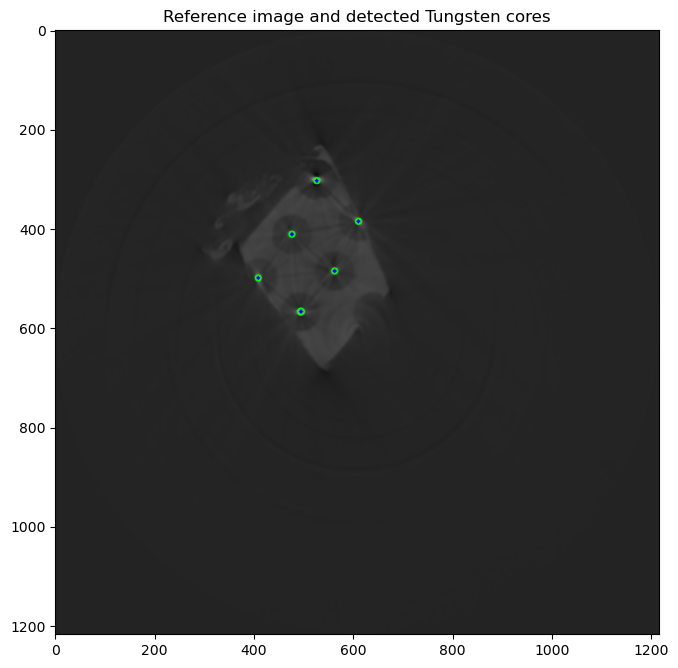

In [12]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");

## Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [13]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

![3D scene to be simulated using gVirtualXray](3d_scene.png)

In [14]:
detector_width_in_pixels = reference_sinogram.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(g_pixel_spacing_in_micrometre, g_pixel_spacing_in_micrometre, "micrometer");

The beam specturm. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [15]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

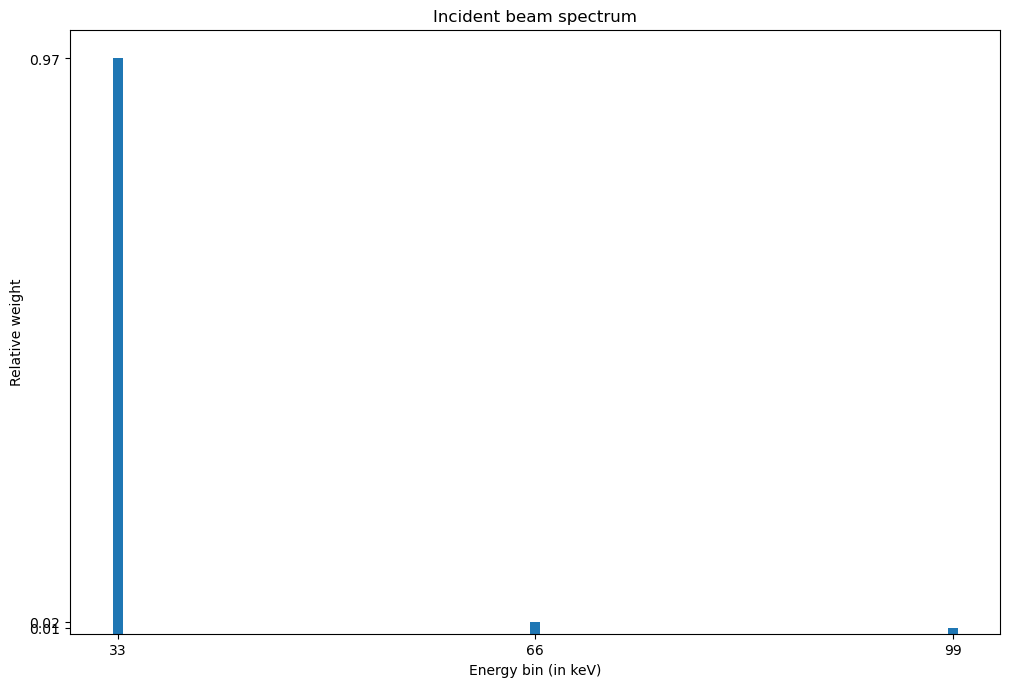

In [16]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);

And the source parameters (beam shape, source position)

In [17]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "mm");
gvxr.usePointSource();
gvxr.useParallelBeam();

The material properties (chemical composition and density)

In [18]:
fiber_radius = 140 / 2; # um
fiber_material = [("Si", 0.5), ("C", 0.5)];
fiber_mu = 2.736; # cm-1
fiber_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];
core_mu = 341.61; # cm-1
core_density = 19.3 # g/cm3

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_mu = 13.1274; # cm-1
matrix_density = 4.42 # g/cm3

## Set the scanned object

In [19]:
gvxr.removePolygonMeshesFromSceneGraph();

# Add the geometries
gvxr.emptyMesh("fiber");
gvxr.emptyMesh("core");

number_of_sectors = 100;

fiber_centre = [0, 0];

for i, cyl in enumerate(circles[0,:]):
#     if i == 0:
#         gvxr.makeCylinder("fiber_" + str(i), number_of_sectors, 815.0, fiber_radius, "micrometer");
#         gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

#         #gvxr.subtractMesh("fiber_" + str(i), "core_" + str(i));

#         gvxr.addMesh("fiber", "fiber_" + str(i));
#         gvxr.addMesh("core",  "core_"  + str(i));

    x = g_pixel_spacing_in_micrometre * -(cyl[0] - reference_CT.shape[1] / 2 + 0.5);
    y = g_pixel_spacing_in_micrometre * (cyl[1] - reference_CT.shape[0] / 2 + 0.5);

    fiber_centre[0] += x;
    fiber_centre[1] += y;
    
    gvxr.makeCylinder("fiber_" + str(i), number_of_sectors, 815.0, fiber_radius, "micrometer");
    gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

    gvxr.translateNode("fiber_" + str(i), y, 0.0, x, "micrometer");
    gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");
    
    gvxr.subtractMesh("fiber_" + str(i), "core_" + str(i));

    gvxr.applyCurrentLocalTransformation("fiber_" + str(i));
    gvxr.applyCurrentLocalTransformation("core_" + str(i));

    gvxr.addMesh("fiber", "fiber_" + str(i));
    gvxr.addMesh("core",  "core_"  + str(i));
    
    #gvxr.saveSTLfile("fiber_" + str(i), "outputs/fiber_" + str(i) + ".stl");
    #gvxr.saveSTLfile("core_" + str(i),  "outputs/core_"  + str(i) + ".stl");
        
fiber_centre[0] /= len(circles);
fiber_centre[1] /= len(circles);

gvxr.saveSTLfile("fiber", "outputs/fiber.stl");
gvxr.saveSTLfile("core",  "outputs/core.stl");

gvxr.setColor("fiber", 1.0, 0.0, 0.0, 1.0);
gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

#gvxr.setLinearAttenuationCoefficient("fiber", fiber_mu, "cm-1");
gvxr.setCompound("fiber", "SiC");
gvxr.setDensity("fiber", fiber_density, "g/cm3");

#gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
gvxr.setElement("core", "W");

gvxr.addPolygonMeshAsInnerSurface("core");
gvxr.addPolygonMeshAsInnerSurface("fiber");

## Simulate the CT acquisition

Compute the raw projections and save the data. For this  purpose, we define a new function and calls it straightaway.

In [20]:
def tomographyAcquisition():
    raw_projections_in_MeV = [];

    for angle_id in range(0, g_number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-g_angular_step * angle_id, 0, 1, 0);
        raw_projections_in_MeV.append(gvxr.computeXRayImage());

    raw_projections_in_MeV = np.array(raw_projections_in_MeV);
    raw_projections_in_keV = raw_projections_in_MeV / gvxr.getUnitOfEnergy("keV");
    
    return raw_projections_in_keV;

In [21]:
raw_projections_in_keV = tomographyAcquisition();

In [22]:
#np.savetxt("outputs/raw_projections.txt", raw_projections);
volume = sitk.GetImageFromArray(raw_projections_in_keV);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'outputs/raw_projections.mha', useCompression=True);

A X-ray projection (energy fluence) is equal to

$$I = \sum_E N_0(E) \times E \times \exp\left(-\sum_n \mu(n,E) \Delta_x(n)\right)$$

- $I$ corresponds to `raw_projections_in_MeV` or `raw_projections_in_keV` in the code above,
- $N_0(E)$ is the number of photons at energy $E$ in the incident X-ray beam, 
- $\mu(n,E)$ is the attenuation coefficient of the material of the $n$-th object for energy $E$, and 
- $\Delta_x(n)$ is the thickness of the material of the $n$-th object crossed by the ray.

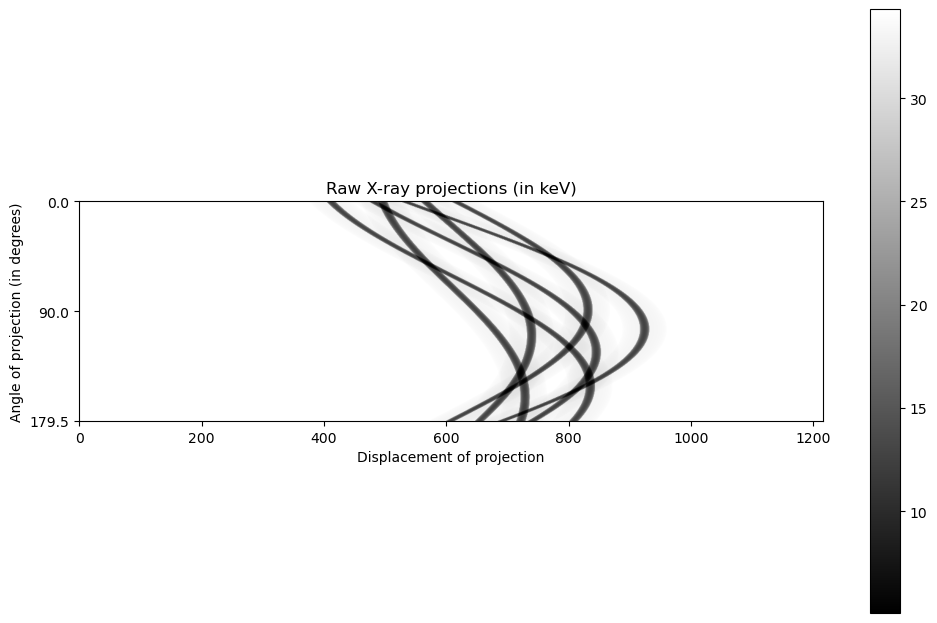

In [23]:
fig=plt.figure();
imgplot = plt.imshow(raw_projections_in_keV[:,raw_projections_in_keV.shape[1]//2,:],
                     cmap='gray');
plt.title("Raw X-ray projections (in keV)");
fig.colorbar(imgplot);
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);

Because the data suffers from a fixed-pattern noise in X-ray imaging in actual experiments, it is necessary to perform the flat-field correction of the raw projections using:

$$normalised\_projections = \frac{raw\_projections − dark\_field}{flat\_field\_image − dark\_field}$$

- $raw\_projections$ are the raw projections with the X-ray beam turned on and with the scanned object, 
- $flat\_field\_image$ is an image with the X-ray beam turned on but without the scanned object, and 
- $dark\_field$ is an image with the X-ray beam turned off.

Note that in our example, $raw\_projections$, $flat\_field\_image$ and $dark\_field$ are in keV whereas $normalised\_projections$ does not have any unit:

$$0 \leq raw\_projections \leq  \sum_E N_0(E) \times E\\0 \leq normalised\_projections \leq 1$$

We define a new function to compute the flat-field correction and calls it straightaway.

In [24]:
def flatFieldCorrection(raw_projections_in_keV):
    dark_field_image = np.zeros(raw_projections_in_keV.shape);
    flat_field_image = np.zeros(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image = np.ones(raw_projections_in_keV.shape) * total_energy;

    normalised_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);
    
    return normalised_projections;

In [25]:
normalised_projections = flatFieldCorrection(raw_projections_in_keV);

In [26]:
#np.savetxt("outputs/normalised_projections.txt", normalised_projections);
volume = sitk.GetImageFromArray(normalised_projections);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'outputs/normalised_projections.mha', useCompression=True);

In the literature, a projection (`raw_projections` in our example) is often modelled as follows:

$$P = \ln\left(\frac{I_0}{I}\right) = -\ln\left(\frac{I}{I_0}\right) = \sum_n \mu(n) \Delta_x$$

$\frac{I}{I_0}$ corresponds to $normalised\_projections$ generated by the flat-field correction. It is therefore necessary to linearise the transmission tomography data using:

$$-\ln(normalised\_projections)$$ 

This new image corresponds to the Radon transform, known as sinogram, of the scanned object in these experimental conditions. Once this is done, we divide the pixels of the sinogram by $\Delta_x$, which is egal to the spacing between two successive pixels along the horizontal axis.

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [27]:
def computeSinogramFromFlatField(normalised_projections):
    simulated_sinogram = -np.log(normalised_projections);
    simulated_sinogram /= g_pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");
    
    return simulated_sinogram;

In [28]:
simulated_sinogram = computeSinogramFromFlatField(normalised_projections);

In [29]:
#np.savetxt("outputs/simulated_sinogram.txt", simulated_sinogram);
volume = sitk.GetImageFromArray(simulated_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'outputs/simulated_sinogram.mha', useCompression=True);

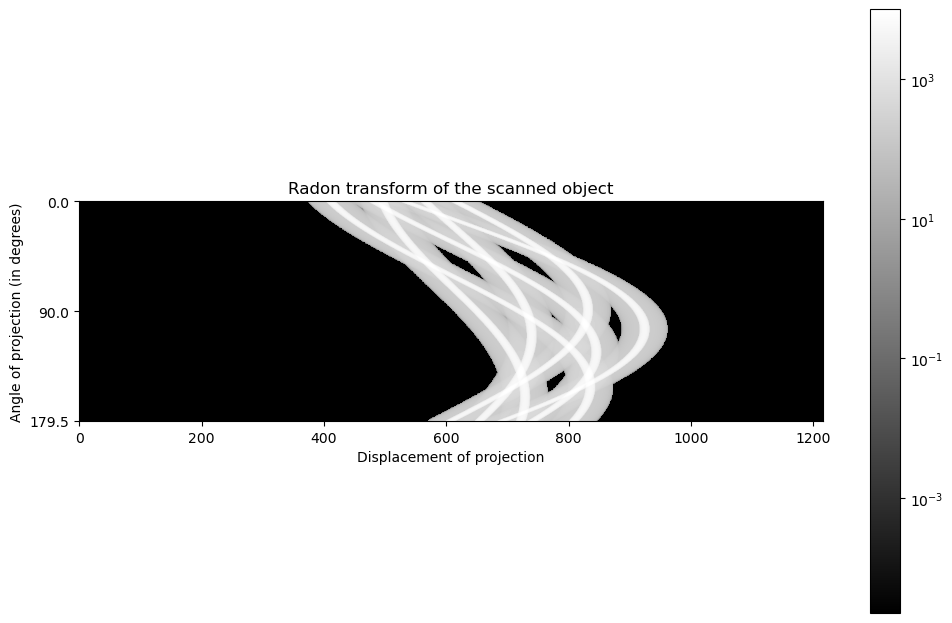

In [30]:
fig=plt.figure();
imgplot = plt.imshow(simulated_sinogram[:,simulated_sinogram.shape[1]//2,:],
                     cmap='gray',
                     norm=LogNorm(vmin=np.min(simulated_sinogram), vmax=np.max(simulated_sinogram)));
plt.title("Radon transform of the scanned object");
fig.colorbar(imgplot);
plt.xlabel("Displacement of projection")
plt.ylabel("Angle of projection (in degrees)")
plt.yticks(tics, labels)
plt.show()

In [31]:
## Tomography reconstruction

### Reconstruction with the Filtered Back Projection (FBP)

In [32]:
reconstruction_fbp = [];

for i in range(simulated_sinogram.shape[1]):
    reconstruction_fbp.append(iradon(simulated_sinogram[:,i,:].T, theta=g_theta, circle=True));

In [33]:
#np.savetxt("outputs/reconstruction_gvxr_fbp.txt", reconstruction_fbp);
volume = sitk.GetImageFromArray(reconstruction_fbp);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'outputs/reconstruction_fbp.mha', useCompression=True);

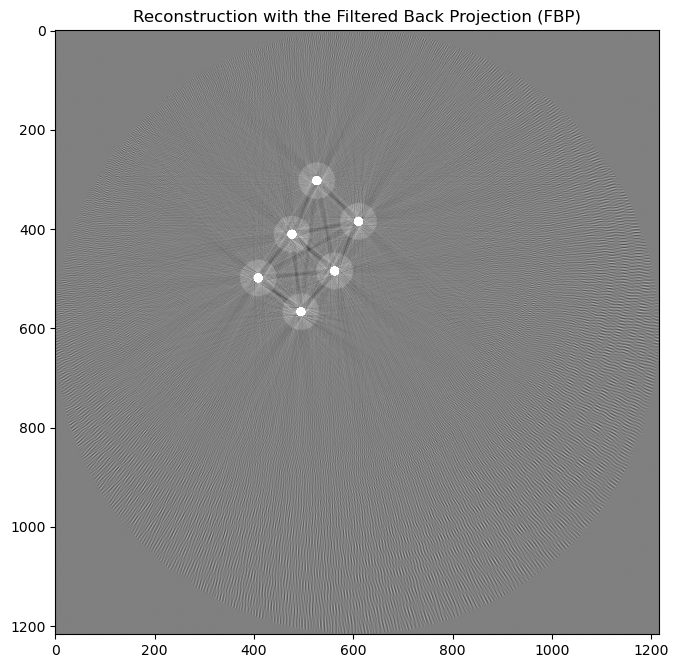

In [34]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=15, vmin=-15)
imgplot = plt.imshow(reconstruction_fbp[len(reconstruction_fbp)//2],
                     cmap='gray',
                     norm=norm);
plt.title("Reconstruction with the Filtered Back Projection (FBP)");

In [35]:
### Reconstruction with the Simultaneous Algebraic Reconstruction Technique (SART)

In [36]:
reconstruction_sart = [];

for i in range(simulated_sinogram.shape[1]):
    reconstruction_sart.append(iradon_sart(simulated_sinogram[:,i,:].T, theta=g_theta));

In [37]:
#np.savetxt("outputs/reconstruction_gvxr_fbp.txt", reconstruction_fbp);
volume = sitk.GetImageFromArray(reconstruction_sart);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'outputs/reconstruction_sart.mha', useCompression=True);

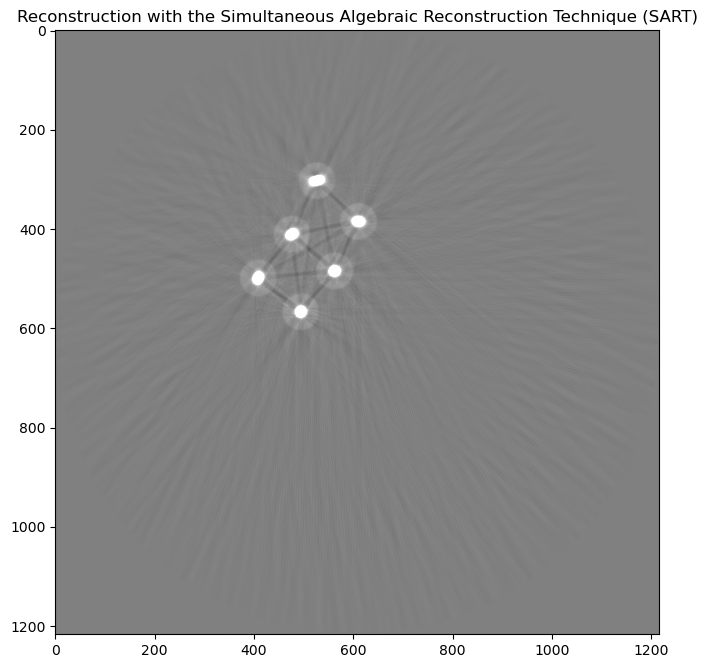

In [38]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=15, vmin=-15)
imgplot = plt.imshow(reconstruction_sart[len(reconstruction_sart)//2],
                     cmap='gray',
                     norm=norm);
plt.title("Reconstruction with the Simultaneous Algebraic Reconstruction Technique (SART)");

### Reconstruction using Tomopy

Reconstructing 1 slice groups with 1 master threads...


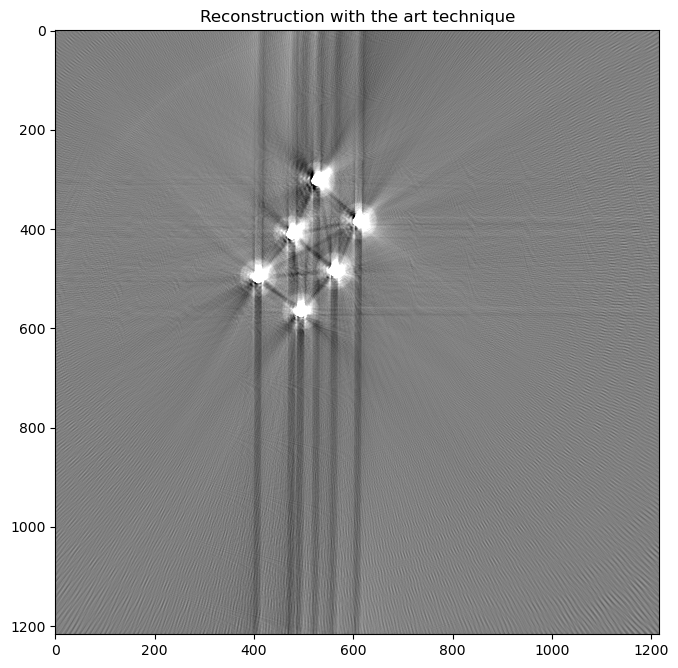

Reconstructing 1 slice groups with 1 master threads...


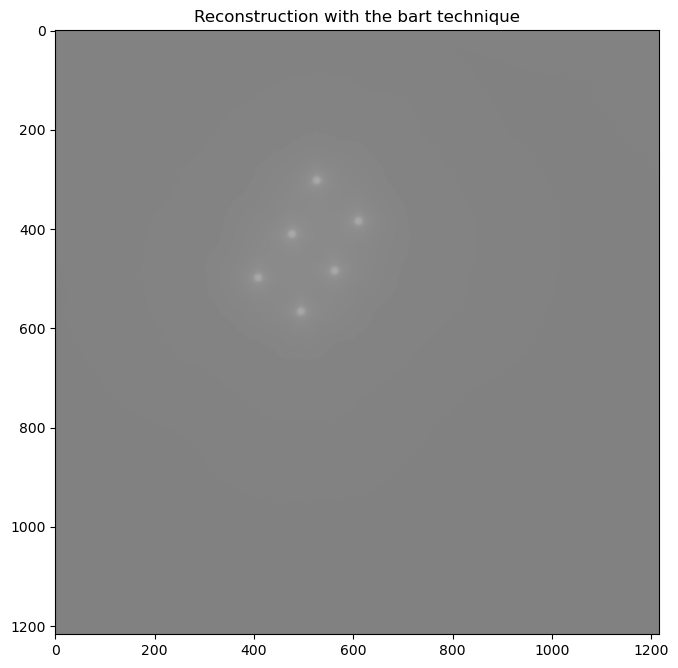

Reconstructing 1 slice groups with 1 master threads...


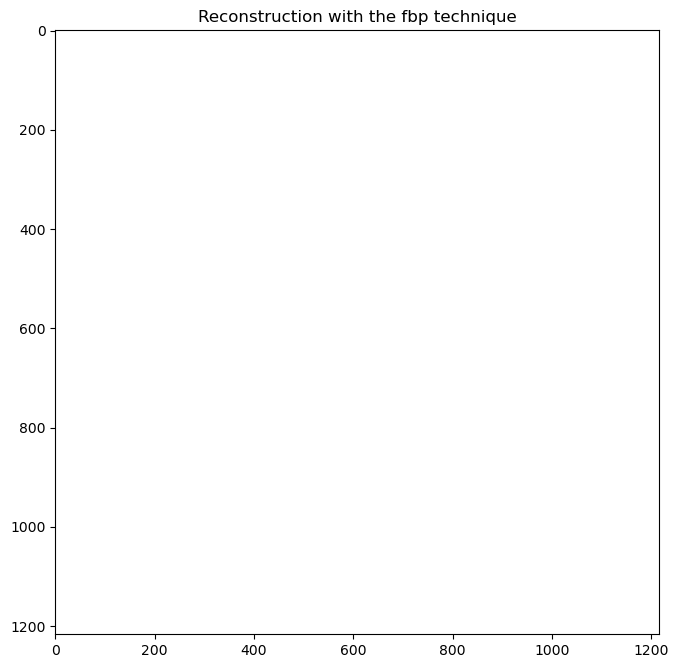

Reconstructing 1 slice groups with 1 master threads...


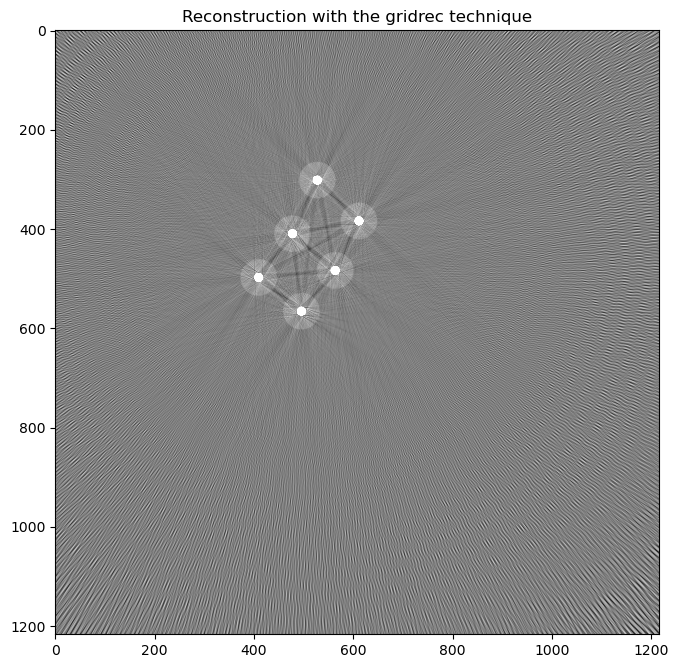

Reconstructing 1 slice groups with 1 master threads...


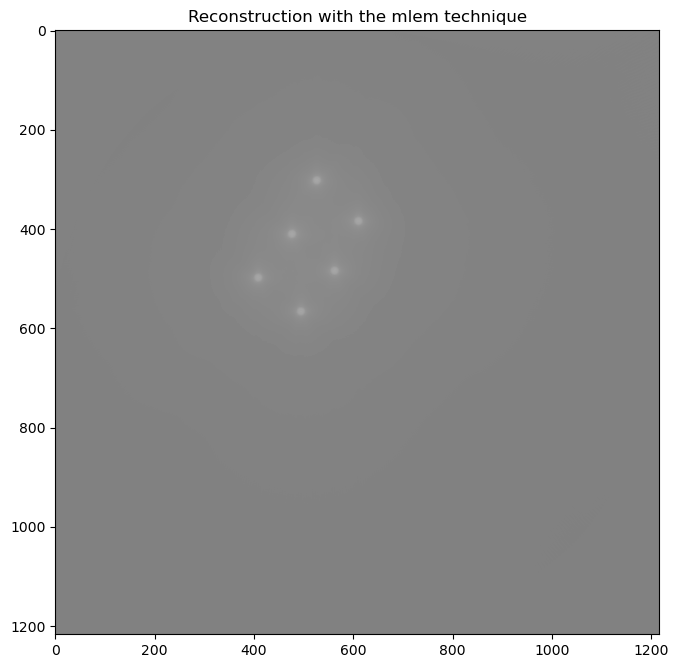

Reconstructing 1 slice groups with 1 master threads...


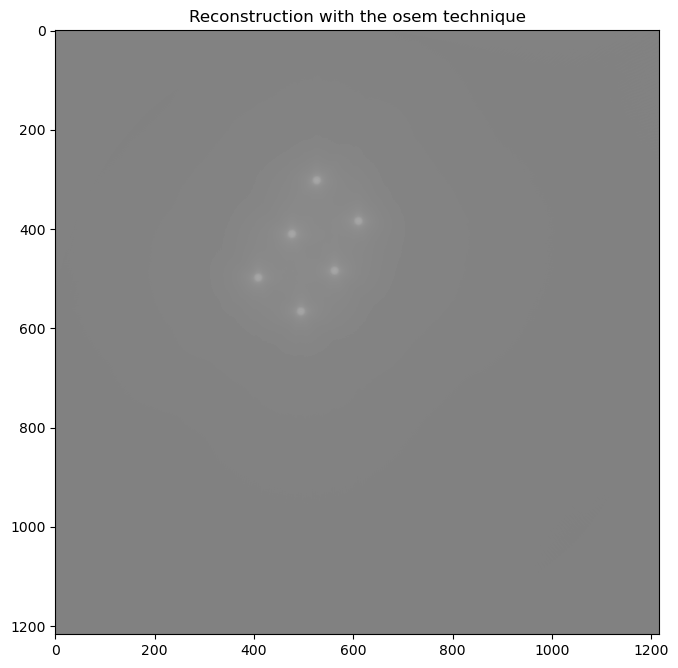

Reconstructing 1 slice groups with 1 master threads...


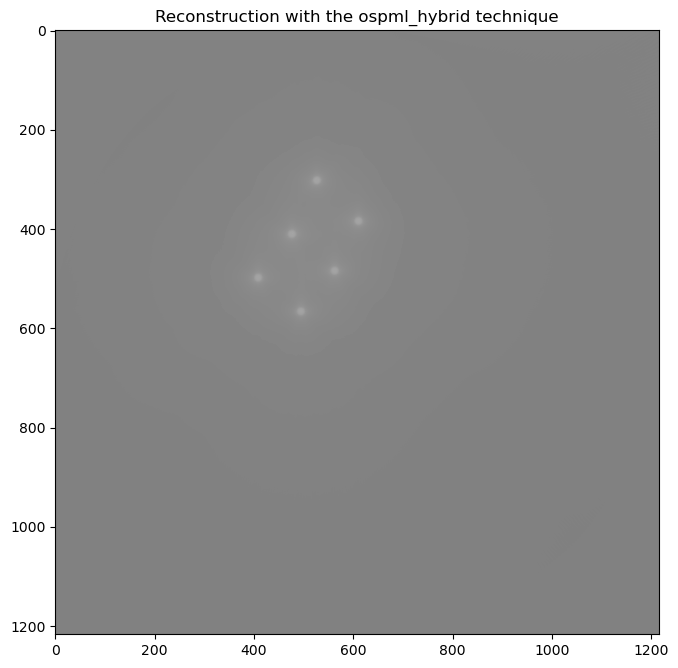

Reconstructing 1 slice groups with 1 master threads...


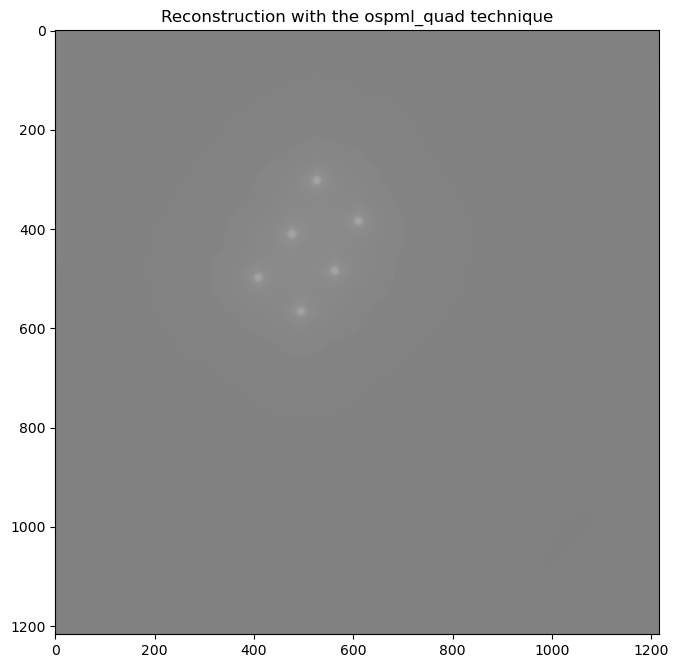

Reconstructing 1 slice groups with 1 master threads...


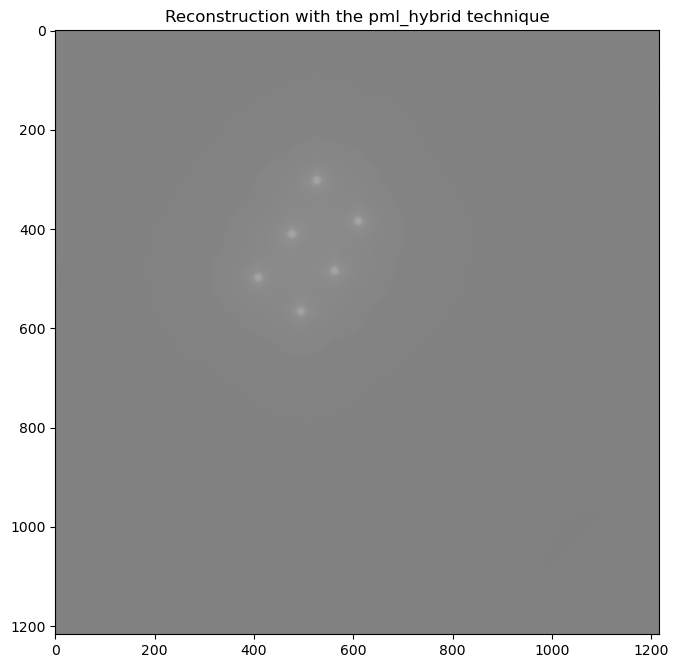

Reconstructing 1 slice groups with 1 master threads...


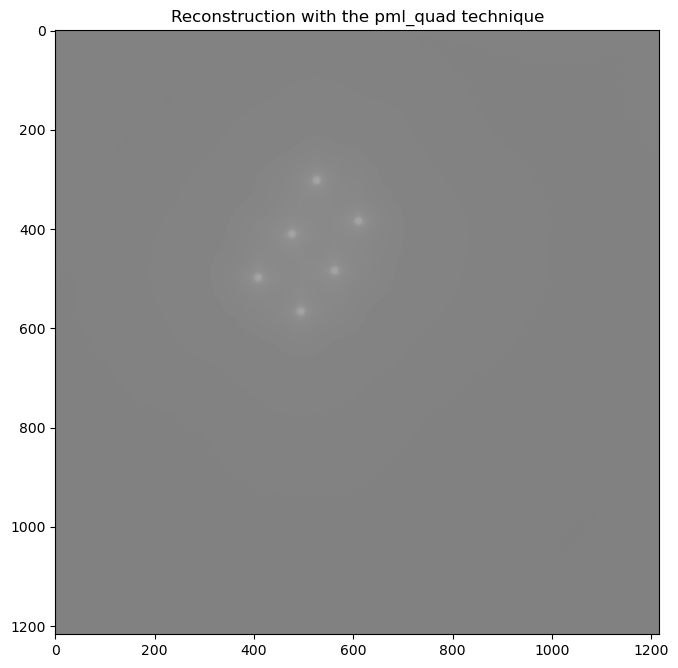

Reconstructing 1 slice groups with 1 master threads...


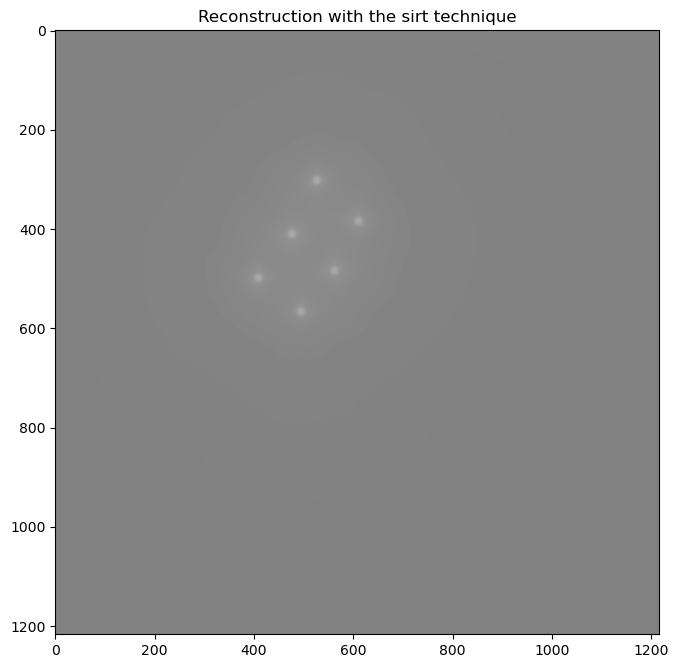

Reconstructing 1 slice groups with 1 master threads...


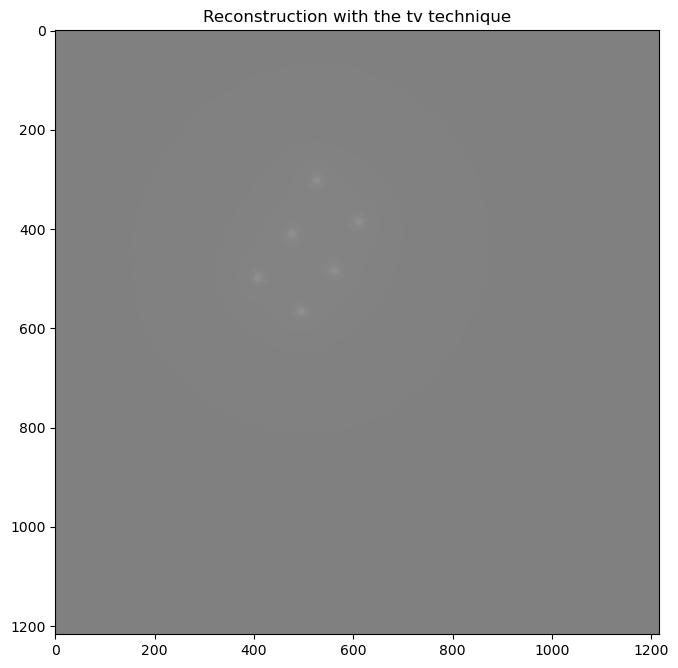

Reconstructing 1 slice groups with 1 master threads...


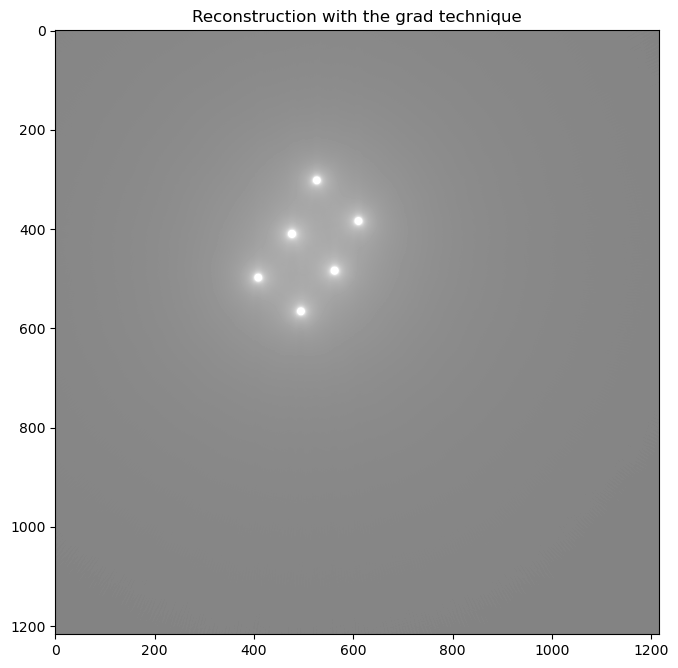

Reconstructing 1 slice groups with 1 master threads...


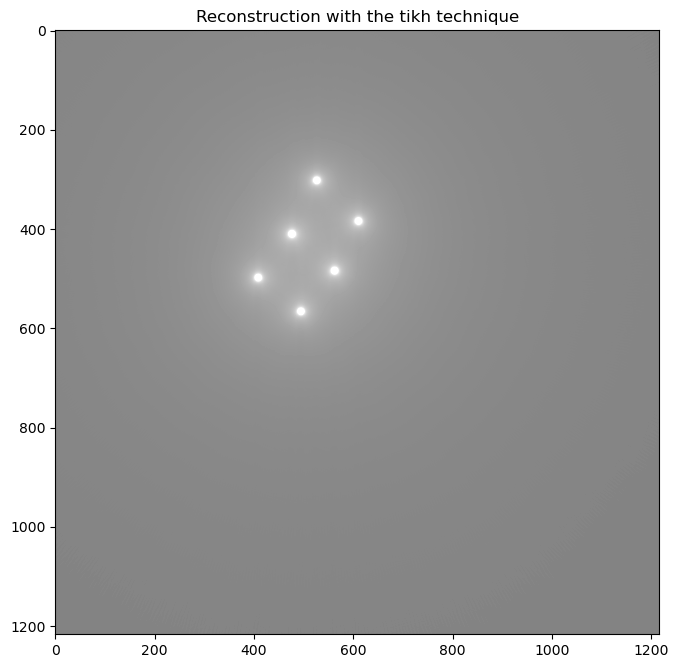

In [39]:
# Set the rotation centre
theta = g_theta / 180.0 * math.pi;
rot_center = int(simulated_sinogram.shape[2]/2);
#rot_center = tomopy.find_center(simulated_sinogram, theta, init=rot_center, ind=0, tol=0.5)

# Perform the reconstruction using Tomopy's algorithms

for algorithm in ["art", "bart", "fbp", "gridrec", "mlem", "osem", "ospml_hybrid", "ospml_quad", "pml_hybrid", "pml_quad", "sirt", "tv", "grad", "tikh"]:
#for algorithm in ["art", "bart", "fbp", "gridrec", "mlem"]:

    reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm=algorithm, sinogram_order=False);
    
    #np.savetxt("outputs/reconstruction_" + algorithm + ".txt", reconstruction_tomopy);
    volume = sitk.GetImageFromArray(reconstruction_tomopy);
    volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
    sitk.WriteImage(volume, "outputs/reconstruction_" + algorithm + ".mhd", useCompression=True);
    
    fig=plt.figure();
    norm = cm.colors.Normalize(vmax=15, vmin=-15)
    imgplot = plt.imshow(reconstruction_tomopy[simulated_sinogram.shape[1]//2,:,:],
                         cmap='gray', norm=norm);
    plt.title("Reconstruction with the " + algorithm + " technique");
    plt.show()

## Normalise the image data

Zero-mean unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (Z-score Normalisation) in machine learning. It is computed as follows:

$$I' = \frac{I - \bar{I}}{\sigma}$$

Where $I'$ is the image after the original image $I$ has been normalised, $\bar{I}$ is the average pixel value of $I$, and $\sigma$ is its standard deviation.

In [40]:
g_reference_sinogram = (reference_sinogram - reference_sinogram.mean()) / reference_sinogram.std();
g_reference_CT       = (reference_CT       - reference_CT.mean())       / reference_CT.std();

In [41]:
#np.savetxt("outputs/normalised_reference_sinogram.txt", g_reference_sinogram);
volume = sitk.GetImageFromArray(g_reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "outputs/normalised_reference_sinogram.mha", useCompression=True);

#np.savetxt("outputs/normalised_reference_CT.txt", g_reference_CT);
volume = sitk.GetImageFromArray(g_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "outputs/normalised_reference_CT.mha", useCompression=True);

In [42]:
def setMatrix(apGeneSet):

    gvxr.removePolygonMeshesFromXRayRenderer();

    # Matrix
    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;

    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 360.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);
    
    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;    
    gvxr.scaleNode("matrix", w, 815, h);

#     print("w:", w, "h:", h, "x:", x, "y:", y);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Matrix
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    gvxr.addPolygonMeshAsOuterSurface("matrix");
    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fiber");

In [43]:
def simulateSinogram():
    raw_projections_in_keV = tomographyAcquisition();
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);
    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

In [44]:
def fitnessFunction(x):
    global best_fitness, matrix_id;
    setMatrix(x);
    
    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
    normalised_simulated_sinogram = (simulated_sinogram - simulated_sinogram.mean()) / simulated_sinogram.std();

    # reconstruct the CT slice
    reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);
    normalised_simulated_CT = (reconstruction_tomopy - reconstruction_tomopy.mean()) / reconstruction_tomopy.std();
    
#     print(normalised_simulated_sinogram.shape, normalised_simulated_sinogram.shape);
    #MAE = np.mean(np.abs(normalised_simulated_image - g_reference_sinogram));
    #ZNCC = np.mean(np.multiply(normalised_simulated_image, g_reference_sinogram));
    
    # Compute the fitness function
    MAE = np.mean(np.abs(normalised_simulated_CT - g_reference_CT));
    ZNCC = np.mean(np.multiply(normalised_simulated_CT, g_reference_CT));
    
    # Save the data
    fitness = abs(1/ ZNCC)
    if best_fitness > fitness:
        best_fitness = fitness;
        
        gvxr.saveSTLfile("matrix", "outputs/matrix_" + str(matrix_id) + ".stl");
        
        #np.savetxt("outputs/reconstruction_gvxr_fbp.txt", reconstruction_fbp);
        
        normalised_simulated_sinogram.shape = (normalised_simulated_sinogram.size//normalised_simulated_sinogram.shape[2], normalised_simulated_sinogram.shape[2]);
        
        volume = sitk.GetImageFromArray(normalised_simulated_sinogram);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "outputs/normalised_simulated_sinogram_" + str(matrix_id) + ".mha", useCompression=True);

        volume = sitk.GetImageFromArray(normalised_simulated_CT);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "outputs/normalised_simulated_CT_" + str(matrix_id) + ".mha", useCompression=True);

        matrix_id += 1;
        
#     best_fitness = min(MAE, best_fitness);
        print("Best:", best_fitness, "MAE:", MAE, "ZNCC:", ZNCC)
    
    return fitness;

In [45]:
best_fitness = sys.float_info.max;
matrix_id = 0;


opts = cma.CMAOptions()
print(opts['tolfun'])
print(opts['tolx'])

opts.set('tolfun', 1e-7)
opts['tolx'] = 1e-7
opts['bounds'] = [5*[-0.5], 5*[0.5]];

#current_best = [-0.12174177,  0.07941929, -0.3949529,  -0.18708068, -0.23998638]#copy.deepcopy(es.result.xbest); # [-0.12174177  0.07941929 -0.3949529  -0.18708068 -0.23998638]

es = cma.CMAEvolutionStrategy(5 * [0], 0.5, opts);


es.optimize(fitnessFunction);

# es.result_pretty();
#solutions = es.ask();
#print("solutions", solutions)

print(es.result.xbest);
print(es.result.fbest);

setMatrix(es.result.xbest);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");


1e-11  #v termination criterion: tolerance in function value, quite useful
1e-11  #v termination criterion: tolerance in x-changes
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=686741, Wed Jan 13 17:39:47 2021)
Reconstructing 1 slice groups with 1 master threads...
Best: 3.7668542410377457 MAE: 0.6721039660951061 ZNCC: 0.26547350547986853
Reconstructing 1 slice groups with 1 master threads...
Best: 2.8088589846602883 MAE: 0.5829115042517622 ZNCC: 0.3560164484800375
Reconstructing 1 slice groups with 1 master threads...
Best: 2.496136790983998 MAE: 0.5425093844309721 ZNCC: 0.4006190700814083
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.496136790983998e+00 1.0e+00 5.

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.9961034290596187 MAE: 0.5164037835485802 ZNCC: 0.500976044348117
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   16    128 1.996103429059619e+00 1.8e+00 1.82e-01  1e-01  2e-01 1:09.7
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.864740913290106 MAE: 0.5541278109613073 ZNCC: 0.5362675280372451
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruct

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.635053943364976 MAE: 0.4590114138332103 ZNCC: 0.6116006166389707
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6289002296921309 MAE: 0.46078002441542065 ZNCC: 0.613911141868403
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   33    264 1.628900229692131e+00 3.3e+00 4.88e-02  1e-02  4e-02 2:24.2
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6264165374467356 MAE: 0.4582199938723464 ZNCC: 0.614848642383993
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6155272070348627 MAE: 0.4536328596862115 ZNCC: 0.618992979904931
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6152284412060303 MAE: 0.45350933278218075 ZNCC: 0.6191074738959758
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice grou

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6141227010646462 MAE: 0.4530276327480127 ZNCC: 0.6195315878652955
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 1.6140808302420075 MAE: 0.4532477097709686 ZNCC: 0.619547659115724
   65    520 1.614080830242008e+00 4.9e+00 4.26e-03  7e-04  2e-03 4:46.9
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   82    656 1.614086242101107e+00 6.5e+00 2.15e-03  2e-04  7e-04 6:00.9
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
  100    800 1.614009407815504e+00 6.7e+00 6.66e-04  5e-05  1e-04 7:17.7
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
  137   1096 1.613953663897342e+00 7.0e+00 8.63e-05  3e-06  8e-06 9:59.8
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
  210   1680 1.613951597843678e+00 2.6e+01 1.22e-05  2e-07  5e-07 15:19.6
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master th

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
  230   18

In [46]:
# Restart
current_best = copy.deepcopy(es.result.xbest); # [-0.12174177  0.07941929 -0.3949529  -0.18708068 -0.23998638]
# es = cma.CMAEvolutionStrategy(current_best, 0.5, opts);

In [47]:
setMatrix(current_best);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");

### Apply the result of the registration

In [48]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
normalised_simulated_sinogram = (simulated_sinogram - simulated_sinogram.mean()) / simulated_sinogram.std();

# reconstruct the CT slice
reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);

Reconstructing 1 slice groups with 1 master threads...


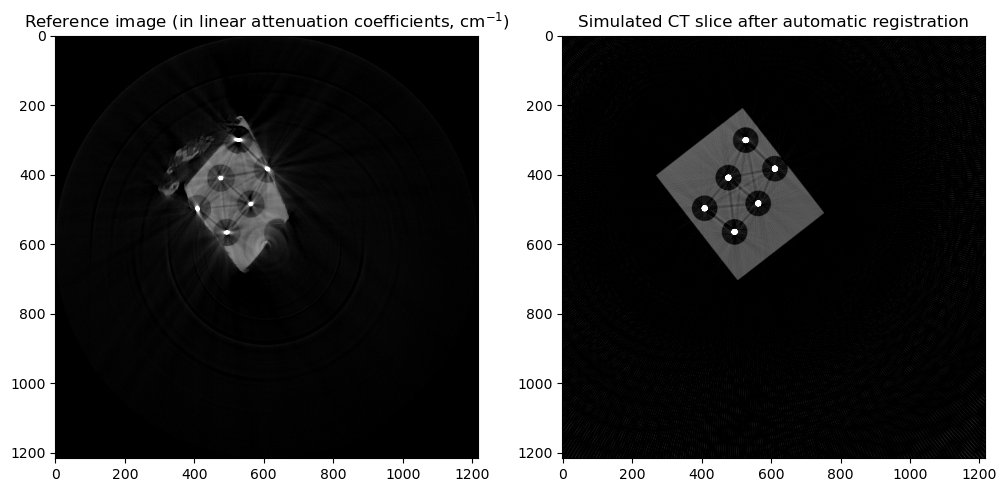

In [49]:
#fig=plt.figure();

norm = cm.colors.Normalize(vmax=50, vmin=0)

fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Horizontally stacked subplots')

ax1.set_title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");
imgplot1 = ax1.imshow(reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(reconstruction_tomopy[len(reconstruction_tomopy)//2],
                     cmap='gray',
                     norm=norm);

# fig.colorbar(imgplot2);


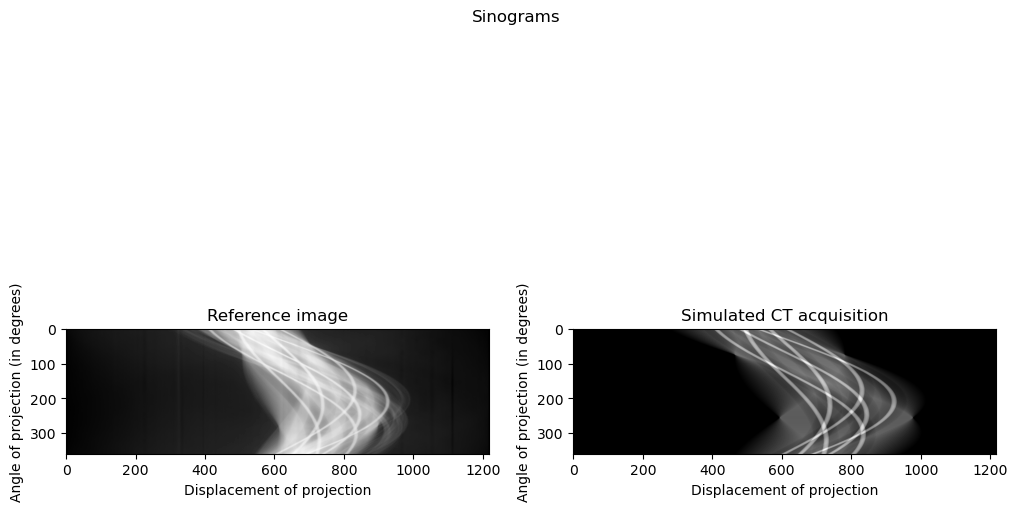

In [50]:
#fig=plt.figure();

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sinograms')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(g_reference_sinogram, cmap="gray");
ax1.set_xlabel("Displacement of projection");
ax1.set_ylabel("Angle of projection (in degrees)");
# ax1.set_yticks(tics, labels);

ax2.set_title("Simulated CT acquisition");
imgplot2 = ax2.imshow(simulated_sinogram[:,simulated_sinogram.shape[1]//2,:],
                     cmap='gray');
ax2.set_xlabel("Displacement of projection");
ax2.set_ylabel("Angle of projection (in degrees)");
# ax2.set_yticks(tics, labels);

# fig.colorbar(imgplot2);
